In [1048]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import math
import IPython.display as IDisplay

# Test dataset

- circle
- moon

In [5]:
circle = pd.read_csv('circle.txt', names=['x','y'])
moon = pd.read_csv('moon.txt', names=['x','y'])
circle.shape, moon.shape

((1500, 2), (1500, 2))

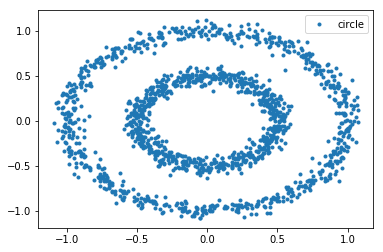

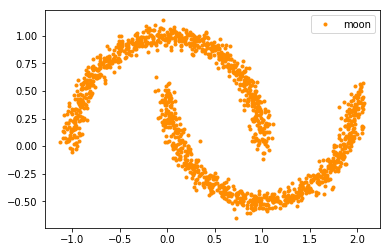

In [12]:
plt.plot(circle['x'], circle['y'],'.',label='circle')
plt.legend()
plt.show()
plt.plot(moon['x'], moon['y'],'.',c='darkorange',label='moon')
plt.legend()
plt.show()

### some common function

In [1085]:
# tool and common function

def showClustering(
    datas, 
    C,
    u=None,
    title='',
    k=None, 
    color_k = ['blue', 'darkorange', 'green', 'deeppink']
):
    if k == None:
        k = len(C[0])
    
    plt.figure(figsize=(10,10))
    for i in range(k):
        if type(u) != type(None):
            plt.plot(u[i][0],u[i][1],'o',
                     c=color_k[i],
                     markersize=150.0, 
                     alpha=0.3
                    )
            plt.plot(u[i][0],u[i][1],'*',
                     c=color_k[i],
                     #markersize=150.0, 
                     alpha=0.3,
                     label='clustering {} mean'.format(i+1)
                    )
        clustering_datas = datas[C[:,i]==1,:]
        plt.plot(clustering_datas[:,0],clustering_datas[:,1],'.',c=color_k[i], label='clustering '+str(i+1))
    
    plt.title(title)
    plt.legend()
    plt.show()

def ReorderGram(gram, c):
    new_order = np.array([])
    for i in range(c.shape[1]):
        new_order = np.append(new_order, np.where(c[:,i]==1)[0])
    new_order = new_order.astype('int32')
    return gram[new_order,:][:,new_order]

def showGram(gram):
    im.show(gram, cmap='gray')
    plt.show()

# K-means and Kernel K-means

In [1036]:
# core function
def Euclidean(x,y):
    if len(x.shape)==1:
        x = x[None,:]
    if len(y.shape)==1:
        y = y[None,:]
    return np.matmul(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.matmul(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T)

def RBFkernel(gamma=1):
    return lambda u,v:np.exp(-1*gamma*Euclidean(u,v));

def KernelTrick(gram_m, c):
    return (
        np.matmul(
        gram_m * np.eye(gram_m.shape[0]), 
        np.ones((gram_m.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_m, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((gram_m.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_m), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
    )**2

def RandomCluster(n,k):
    c = np.zeros((n,k))
    c[np.arange(n),np.random.randint(k,size=n)] = 1             
    return c

def RandomMean(k,dim):
    return -1 + 2*np.random.random((k,dim))

def kmeans(datas, k, initial_u=None, initial_c=None,isKernel=False):
    if isKernel:
        gram_matrix = datas
        c = initial_c if type(initial_c)!=type(None) \
            else RandomCluster(datas.shape[0],k)
    else:
        u = initial_u if type(initial_u)!=type(None) \
            else RandomMean(k,datas.shape[1])
        c = np.zeros((datas.shape[0],k))
        
    while(1):
        # E-step
        if not isKernel:
            w = Euclidean(datas, u)
        else:
            w = KernelTrick(gram_matrix, c)

        # M-step
        update_c = np.zeros(w.shape)
        update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    
        delta_c = np.count_nonzero(np.abs(update_c - c))
        if not isKernel:
            u = np.matmul(update_c.T, datas) / np.sum(update_c, axis=0)[:,None]
        else:
            u = None
        
        yield update_c, u
        
        if delta_c == 0:
            break
        
        c = update_c
    
    return

# K-means

In [1090]:
# initial setting
data_source = np.array(circle)
k = 4

launcher = kmeans(data_source, k)

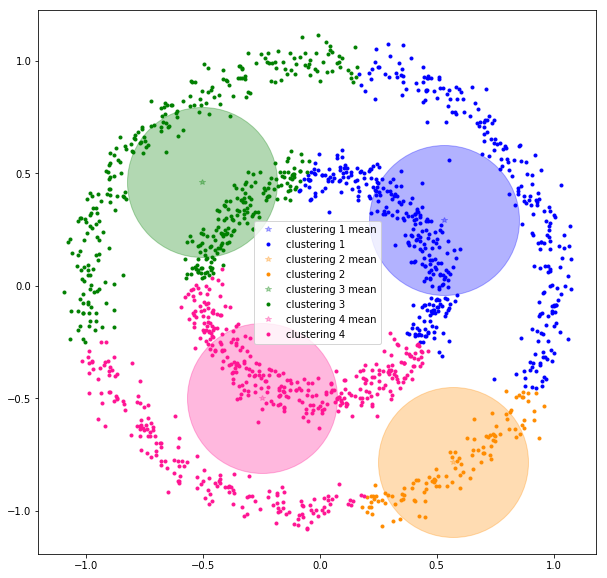

In [1078]:
new_c, new_u = next(launcher)
showClustering(data_source, new_c, new_u)

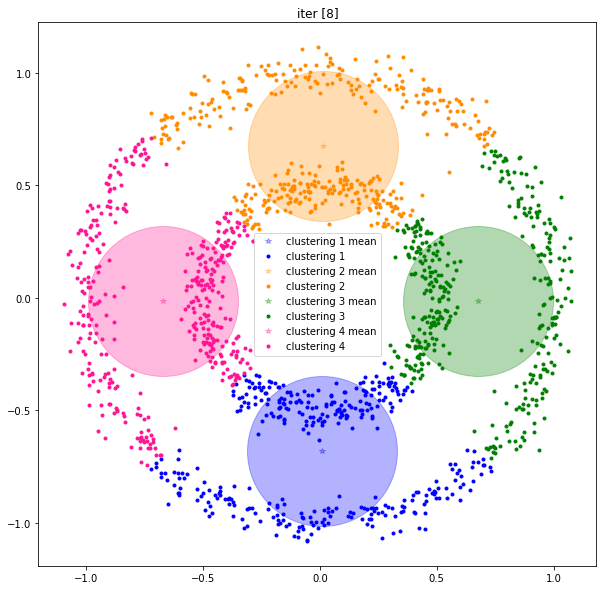

'use 8 counts to converge'

In [1091]:
iter_count = 0
for new_c, new_u in launcher:
    IDisplay.clear_output(wait=True)
    iter_count += 1
    showClustering(data_source, new_c, new_u, title='iter [{}]'.format(iter_count))
    

'use {} counts to converge'.format(iter_count)

# kernel K-means

$$ \\
\min_{C_1...C_k} \sum_{i=1}^k\sum_{x_j \in C_i} || \phi(x_j) - u_i^\phi ||^2 \\
|| \phi(x_j) - u_k^\phi || = || k(x_j, x_j) - \frac{2}{|C_k|}\sum_n\alpha_{kn} k(x_j, x_n) + \frac{1}{|C_k|^2}\sum_p\sum_q\alpha_{kp}\alpha_{kq} k(x_p, x_q) ||
$$

rewrite to numpy format

- n : data length
- d : input dims
- k : clustering number

- D : data
    - n*d 
- C : whick clusering (1 mean belong this cluserting)
    - n*k
- k(D,D) : gram matrix
    - n*n
$$ \\
matmul(k(D,D)*eye(n),ones((n,k))) + -2*\frac{matmul(k(D,D),C)}{sum(C)} +  \frac{matmul(ones((n,k)),(C^Tk(D,D)C)*eye(k))}{sum(C)^2}
$$

In [1092]:
# initial setting
data_source = np.array(circle)
k = 4
kernel = RBFkernel(15)
gram_matrix = kernel(data_source, data_source)

launcher = kmeans(gram_matrix, k, isKernel=True)

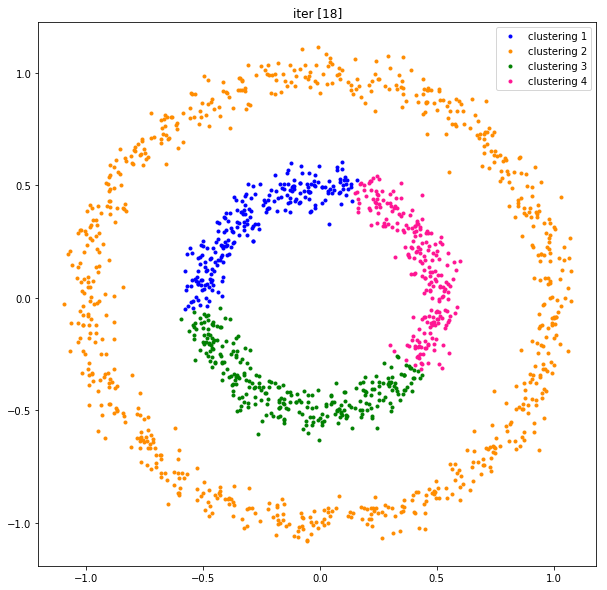

'use 18 counts to converge'

In [1093]:
iter_count = 0
for new_c, new_u in launcher:
    IDisplay.clear_output(wait=True)
    iter_count += 1
    showClustering(data_source, new_c, new_u, title='iter [{}]'.format(iter_count))

'use {} counts to converge'.format(iter_count)

# 我是分隔線

In [1013]:
# initial setting
k = 2
data_source = np.array(circle)

# initial parameters
data_len = data_source.shape[0]
x_dims = data_source.shape[1]
u = [[random.random() for _ in range(x_dims)] for _ in range(k)]
#u = [[0.0 for _ in range(x_dims)] for _ in range(k)]
u = np.array(u)

#u = np.array([[0.01,-0.01],[-0.01,0.01]])
u

In [698]:
# E-step
# w = len(data)*k
# c = len(data)*k (1 mean belong to this clustering)

w = np.matmul(data_source**2, np.ones((x_dims, k))) \
    + np.matmul(np.ones((data_len,x_dims)), (u**2).T) \
    - 2*np.dot(data_source, u.T)
#showClustering(data_source, c, u)

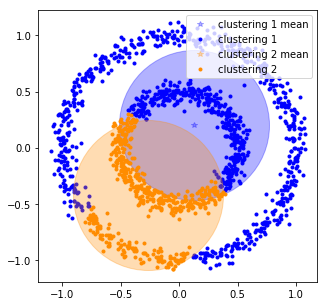

In [1075]:
# M-step
# update u = k*x_dims

c = np.zeros(w.shape)
c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

u_update = np.matmul(c.T, data_source) / np.sum(c, axis=0)[:,None]

#showClustering(data_source, c, u)

u = u_update

showClustering(data_source, c, u_update)

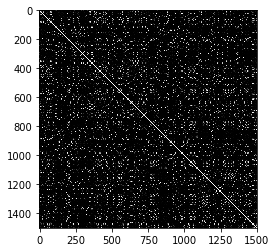

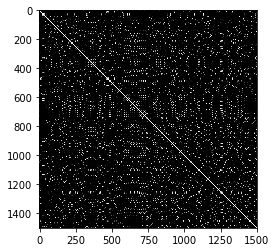

In [885]:
# initial setting
kernel = RBFkernel(13.66)
data_source = np.array(circle)
k = 2

# initial parameters
gram_matrix = kernel(data_source, data_source)
c = np.zeros((data_source.shape[0],k))
c[np.arange(c.shape[0]),np.random.randint(k,size=c.shape[0])] = 1

plt.imshow(gram_matrix, cmap='gray')
plt.show()
plt.imshow(ReorderGram(gram_matrix,c), cmap='gray')
plt.show()

In [962]:
# E-step

w = np.matmul(
        gram_matrix * np.eye(data_source.shape[0]), 
        np.ones((data_source.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_matrix, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((data_source.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_matrix), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
w = w**2

0


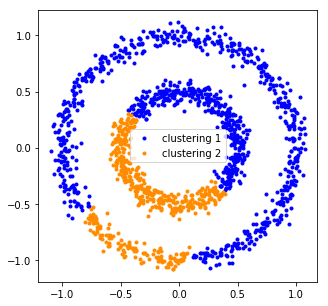

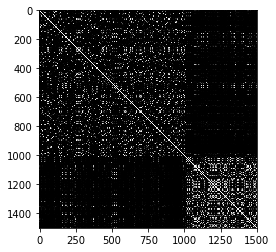

In [963]:
# M-step

update_c = np.zeros(w.shape)
update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

delta_c = np.count_nonzero(np.abs(update_c - c))

c = update_c

print(delta_c)

showClustering(data_source, update_c)
plt.imshow(ReorderGram(gram_matrix,c), cmap='gray')
plt.show()

### spectral clustering